# Plot scan

In [32]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from itertools import product
import seaborn as sns
import sys
sys.path.append('../')
from auxPlots import interpolateData,getContours,saveContours
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [33]:
#Load scan data
dataDF = pd.read_pickle('./ewkRecast.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

### Get k-factors

In [34]:
dataDF['kfactor'] = 1.2
dataDF['robs'] = dataDF['robs']*dataDF['kfactor']
dataDF['robs_comb'] = dataDF['robs_comb']*dataDF['kfactor']

In [35]:
kfactor = dataDF['kfactor'].unique()[0]

### Define colors and plotting order

In [36]:
colors = sns.color_palette("Paired",10)
colorsPink = sns.color_palette("colorblind",8)
colorDict = {'HighPT' : colorsPink[4], #light pink
             'Trackless' : colors[4] }
srs = {'HighPT' : dataDF[(dataDF['SR'] == 'HighPT')], 'Trackless' : dataDF[(dataDF['SR'] == 'Trackless')]}

atlasCurve = np.genfromtxt('../../ATLAS_data/HEPData-ins2628398-v1-csv/excl_ewk_obs_nominal.csv',delimiter=',',comments='#')

### Plot excluded points grouped by most excluding analysis

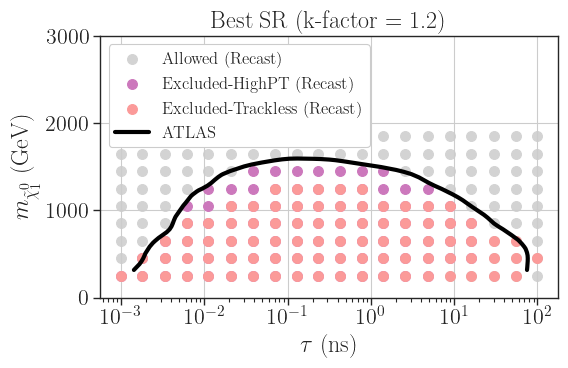

In [37]:

plt.figure(figsize=(6,4))
allowed = dataDF[dataDF['robs'] < 1.0]
n = 0
for sr,data in srs.items():
    # if sr != 'Trackless': continue
    excluded = data[data['robs'] > 1.0]
    allowed = data[data['robs'] < 1.0]
    x = allowed['tau_ns']
    y = allowed['mLLP']
    if n == 0:
        plt.scatter(x,y,color='lightgray',s=50,label='Allowed (Recast)',zorder=-1)
        n += 1
    x = excluded['tau_ns']
    y = excluded['mLLP']
    color = colorDict[sr]
    # plt.scatter(x,y,color=color,label=sr,s=50)
    plt.scatter(x,y,color=color,label='Excluded-%s (Recast)' %sr,s=50,zorder=2)

plt.plot(atlasCurve[:,0],atlasCurve[:,1],linewidth=3,c='black',linestyle='solid',label='ATLAS')
lgd = plt.legend(loc='upper left',framealpha=1.,fontsize=12)
plt.xscale('log')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
plt.tight_layout()
# plt.xlim(1e-3,30)
plt.ylim(0,3000)
plt.grid()
plt.title('Best SR (k-factor = %1.1f)' %kfactor)
plt.tight_layout()
# plt.savefig('recast_Fig11.png')
plt.show()

### Interpolate for a denser grid

In [38]:
pts = srs['Trackless'][['tau_ns','mLLP']].to_numpy()
robs = srs['Trackless']['robs_comb']
newPts = np.array(list(product(np.linspace(np.log10(pts[:,0].min()), np.log10(pts[:,0].max()),100),
                                      np.linspace(pts[:,1].min(),pts[:,1].max(),100))))
muPts = griddata(list(zip(np.log10(pts[:,0]),pts[:,1])),robs,newPts)
newPts = newPts[~np.isnan(muPts)]
muPts = muPts[~np.isnan(muPts)]
newPts[:,0] = 10**newPts[:,0]

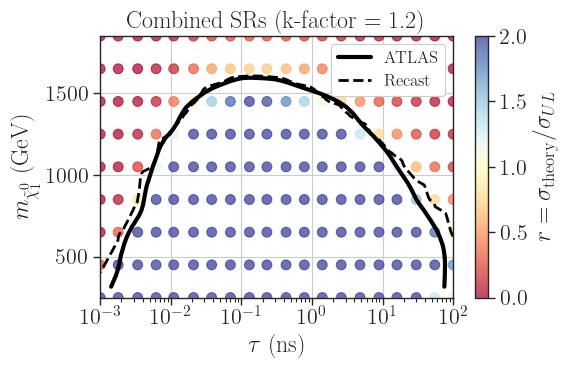

In [43]:

plt.figure(figsize=(6,4))
data = srs['Trackless'] # Use trackless SR just to avoid duplicated points
x = data['tau_ns']
y = data['mLLP']
z = data['robs_comb']
plt.scatter(x,y,c=z,s=50,cmap=cm,vmin=0,vmax=2,alpha=0.7)
cbar = plt.colorbar(label=r'$r = \sigma_{\rm theory}/\sigma_{UL}$')
# plt.scatter(x,y,color='lightgray',s=50,label='Allowed (Recast)')
plt.tricontour(newPts[:,0],newPts[:,1],muPts,levels=[1.0],
            linewidths=2,linestyles='dashed',colors='black')

plt.plot(atlasCurve[:,0],atlasCurve[:,1],linewidth=3,c='black',linestyle='solid',label='ATLAS')
plt.plot([],[],label='Recast',linewidth=2.0,linestyle='dashed',color='black')
lgd = plt.legend(loc='upper right',framealpha=1.,fontsize=12)
plt.xscale('log')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
plt.tight_layout()
# plt.xlim(1e-3,30)
# plt.ylim(0,2500)
plt.grid()
plt.title('Combined SRs (k-factor = %1.1f)' %kfactor)
plt.tight_layout()
plt.savefig('recast_Fig11.png')
plt.show()